In [110]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from sklearn.utils import shuffle

In [111]:
class SignBase:
    _PATH = ''
    VALUE = None
    IMAGES = []
    LABELS = []
    PIXELS = []

    @classmethod
    def read(cls):
        if not cls.IMAGES:
            cls.IMAGES.extend([cv2.imread(os.path.join(cls._PATH, img_name), cv2.IMREAD_UNCHANGED) 
                               for img_name in os.listdir(cls._PATH)])
            SignBase.IMAGES.extend(cls.IMAGES)
            SignBase.LABELS.extend([cls.VALUE] * len(cls.IMAGES))

    @staticmethod
    def prepare():
        SignBase.IMAGES, SignBase.LABELS = shuffle(SignBase.IMAGES, SignBase.LABELS)
        SignBase.PIXELS = np.array([image.flatten() for image in SignBase.IMAGES])/255
        SignBase.LABELS = np.array(SignBase.LABELS)


class Sign30(SignBase):
    _PATH = 'subset_homework/class_id_0'
    VALUE = 0
    IMAGES = []


class Sign50(SignBase):
    _PATH = 'subset_homework/class_id_1'
    VALUE = 1
    IMAGES = []


SIGNS = [Sign30, Sign50]

In [112]:
for sign_type in SIGNS:
    sign_type.read()
    print(f'"{sign_type.VALUE}" amount = {len(sign_type.IMAGES)}')

SignBase.prepare()

"0" amount = 2220
"1" amount = 2250


In [113]:
plt.rcParams['figure.figsize'] = [15, 6]
def draw_random(images, labels):
    images_count = len(images)
    for cnt, idx in enumerate(np.random.randint(0, images_count, 10)):
        plt.subplot(2,5,cnt+1)
        plt.imshow(images[idx], cmap='gray', vmin=0, vmax=255)
        plt.title(labels[0] if len(labels) != images_count else labels[idx]), plt.axis(False)

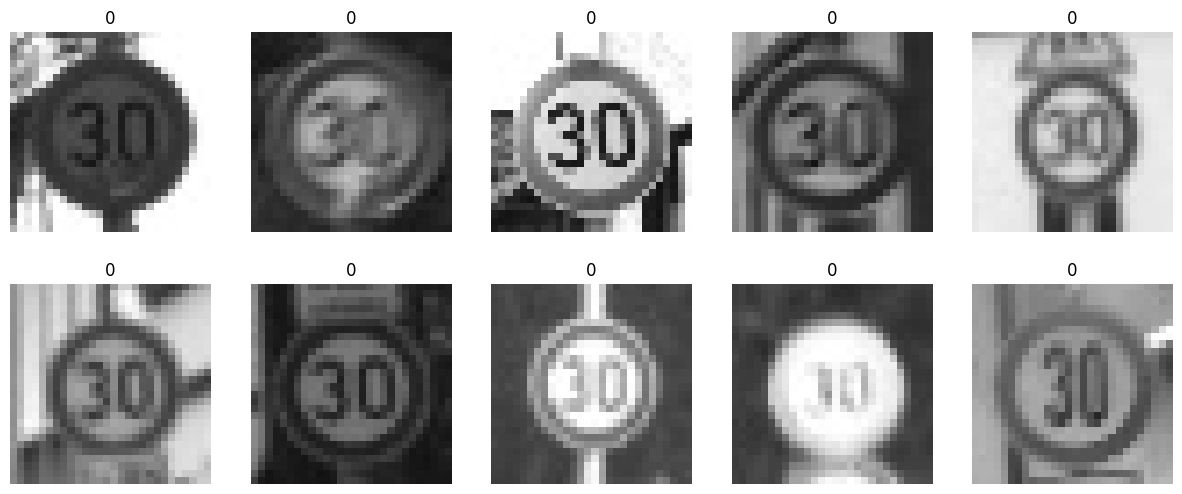

In [114]:
draw_random(Sign30.IMAGES, [Sign30.VALUE])

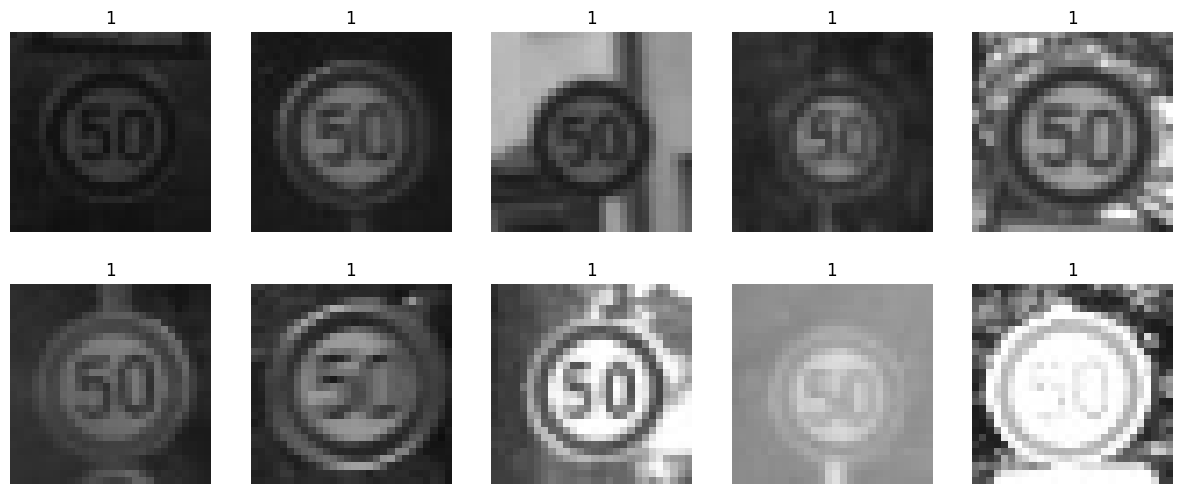

In [115]:
draw_random(Sign50.IMAGES, [Sign50.VALUE])

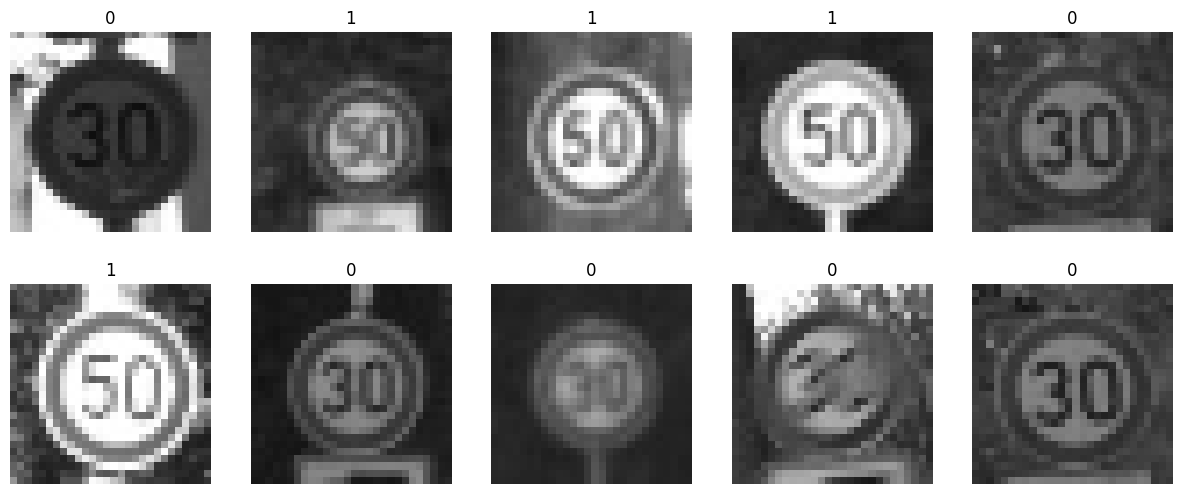

In [116]:
draw_random(SignBase.IMAGES, SignBase.LABELS)

In [117]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input

In [118]:
inputs = Input(shape=(SignBase.PIXELS.shape[1], ))
outputs = Dense(1, activation="linear")(inputs)
model = Model(inputs, outputs)

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           785 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 785 (3.07 KB)

 Trainable params: 785 (3.07 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:
model.compile(optimizer ='adam', loss = 'mean_squared_error')

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 0.3454
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 0.2209
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 0.1852
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 0.1549
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 0.1486
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 0.1260
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 0.1139
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 0.1062
Epoch 9/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.1030
Epoch 10/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - loss: 0.0982


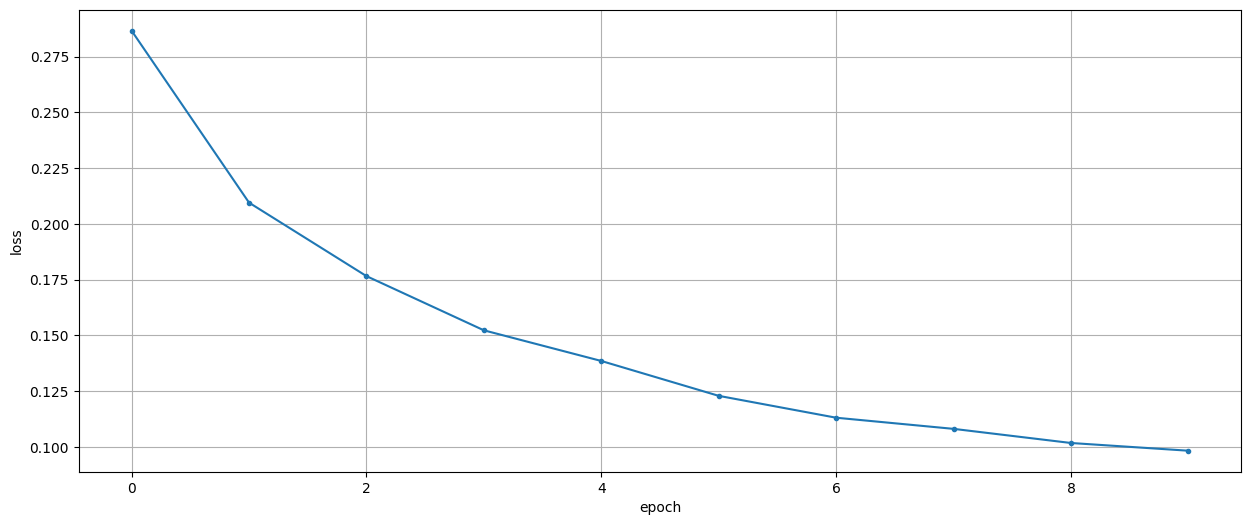

In [120]:
history = model.fit(SignBase.PIXELS, SignBase.LABELS, epochs=10, batch_size=32)

def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))
    plt.plot(epochs, h['loss'], '.-'), plt.grid(True)
    plt.xlabel('epoch'), plt.ylabel('loss')

plot_history(history)

[0.4090481] [0.4090481]


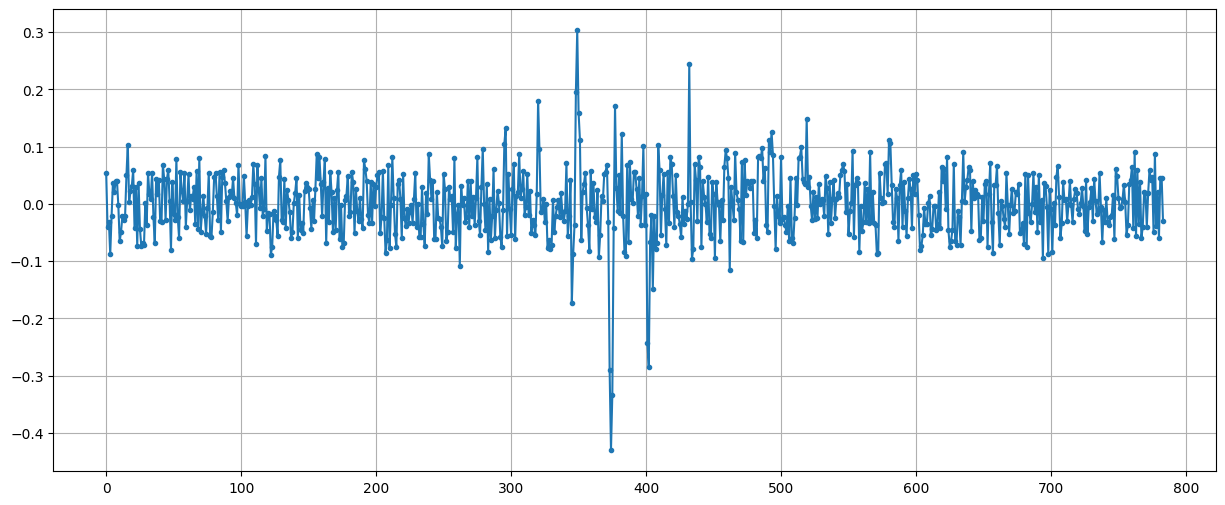

In [121]:
plt.plot(model.layers[1].weights[0].numpy(), '.-'), plt.grid(True)
print(model.layers[1].weights[1].numpy(), model.layers[1].bias.numpy())

In [122]:
predictions = model.predict(SignBase.PIXELS).squeeze()
predictions = predictions > 0.5

def calc_accuracy(predictions):
    correct = 0
    for prediction, label in zip(predictions, SignBase.LABELS):
        if prediction == label:
            correct = correct + 1

    return correct/len(SignBase.LABELS)
    

single_neuron_accuracy = calc_accuracy(predictions)
print('Accuracy', single_neuron_accuracy)

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step
Accuracy 0.9029082774049217


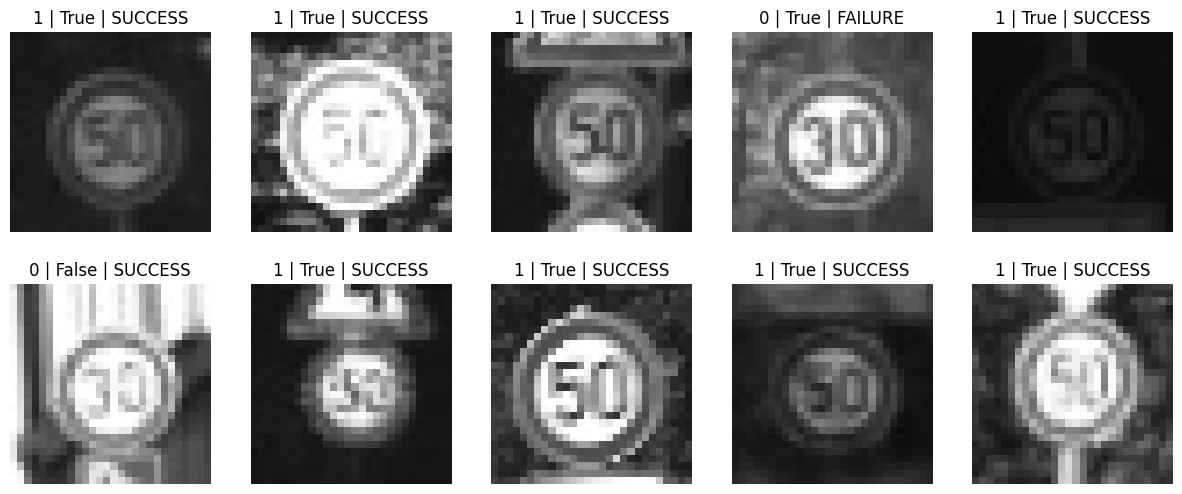

In [123]:
draw_random(SignBase.IMAGES, ['{} | {} | {}'.format(label, prediction, 'SUCCESS' if bool(label) == prediction else 'FAILURE') 
                              for label, prediction in zip(SignBase.LABELS, predictions)])

In [124]:
ACTIVATION_TYPE = 'relu'

inputs = Input(shape=(SignBase.PIXELS.shape[1], ))
hidden = Dense(512, activation=ACTIVATION_TYPE)(inputs)
hidden = Dense(256, activation=ACTIVATION_TYPE)(hidden)
outputs = Dense(1, activation="linear")(hidden)
model = Model(inputs, outputs)

model.summary()
model.compile(optimizer ='adam', loss = 'mean_squared_error')

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8171
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1895
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1569
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1040
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0967
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0860
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0772
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0806
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0673
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0632
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0572
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0670
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0541
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0503
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0527
Epoch 16/50
70/70 ━

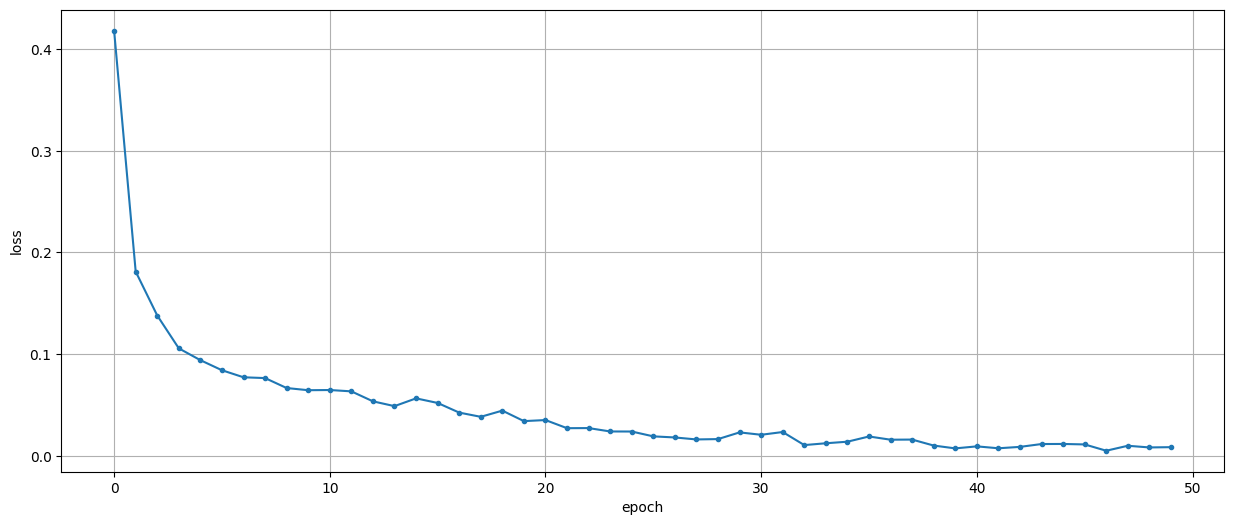

In [125]:
history = model.fit(SignBase.PIXELS, SignBase.LABELS, epochs=50, batch_size=64)
plot_history(history)

In [126]:
predictions = model.predict(SignBase.PIXELS).squeeze()
predictions = predictions > 0.5

multi_neuron_accuracy = calc_accuracy(predictions)
print('Accuracy single nueron', single_neuron_accuracy)
print('Accuracy multi nueron', multi_neuron_accuracy)

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
Accuracy single nueron 0.9029082774049217
Accuracy multi nueron 0.9957494407158837


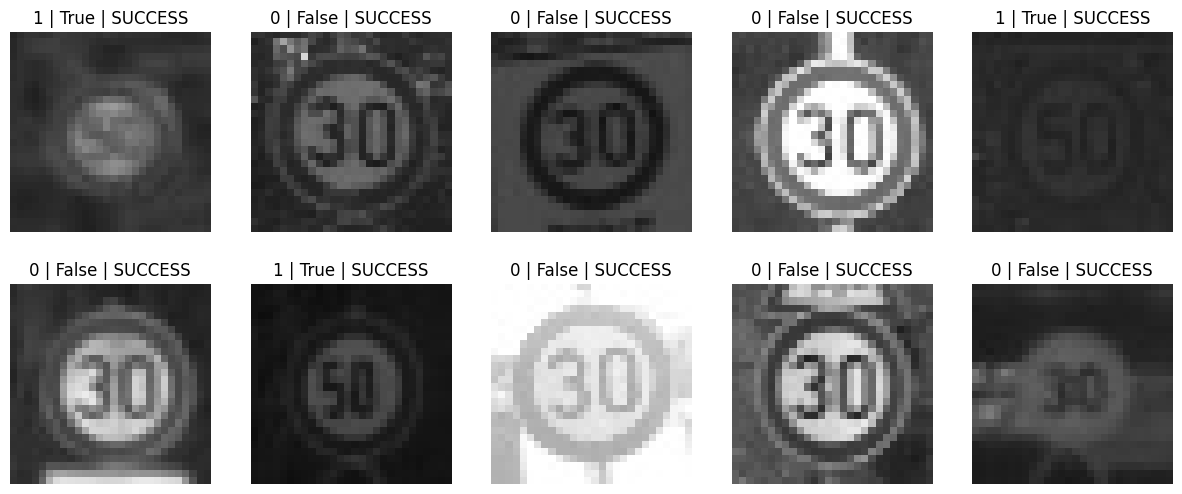

In [127]:
draw_random(SignBase.IMAGES, ['{} | {} | {}'.format(label, prediction, 'SUCCESS' if bool(label) == prediction else 'FAILURE') 
                              for label, prediction in zip(SignBase.LABELS, predictions)])